# **Importing the Necessary Libraries**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay

In [ ]:
!pip install opendatasets --upgrade

# **Downloading the Dataset (Kaggle)**

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dariuschao346
Your Kaggle Key: ··········


100%|██████████| 2.70G/2.70G [01:15<00:00, 38.3MB/s]


In [ ]:
data_dir = '/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'

# **Preprocessing the Data**

In [ ]:
# Set image dimensions and batch size for datasets
batch_size = 128
img_height = 224
img_width = 224

In [ ]:
# Training dataset
train_set = tf.keras.utils.image_dataset_from_directory(
  data_dir + '/train',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 70295 files belonging to 38 classes.


In [ ]:
# Validation dataset
val_set = tf.keras.utils.image_dataset_from_directory(
  data_dir + '/valid',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17572 files belonging to 38 classes.


In [ ]:
# Split ~10% of validation dataset into testing dataset since there is no test dataset
val_batches = tf.data.experimental.cardinality(val_set)
test_set = val_set.take((val_batches) // 10)
val_ds = val_set.skip((val_batches) // 10)

In [ ]:
# Check the class names
class_names = train_set.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

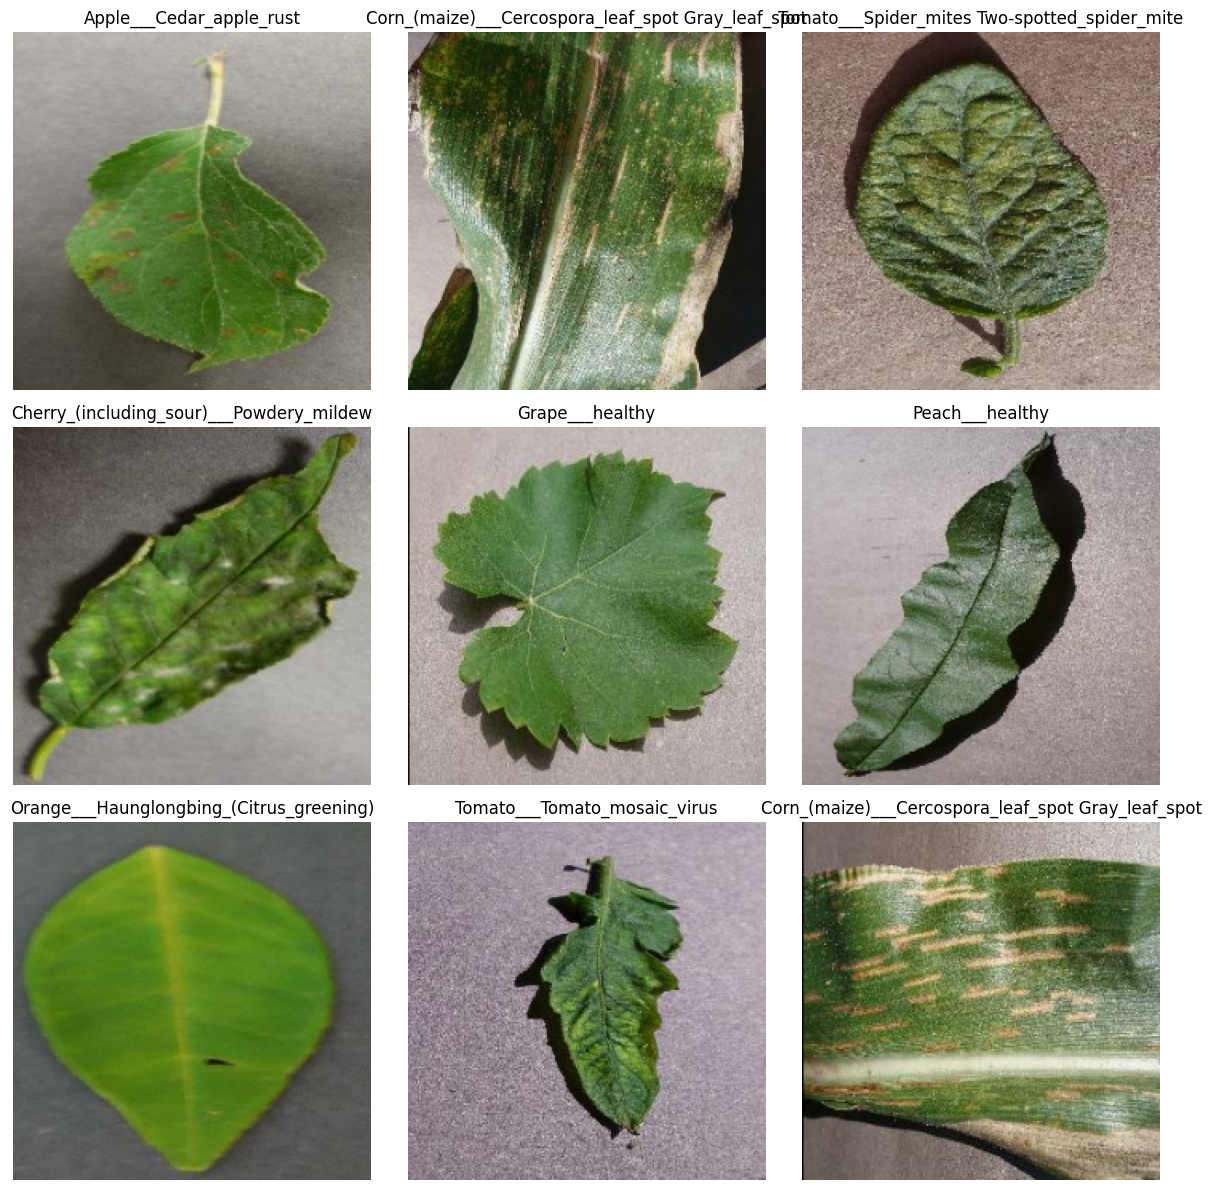

In [ ]:
# Visualize some images from the training dataset
plt.figure(figsize=(12, 12))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], fontsize=12)
        plt.axis("off")
plt.tight_layout()
plt.show()

# **Data Augmentation**

The dataset is already augmented so there was no need for additional augmentation.

In [ ]:
'''data_aug = keras.Sequential([
    # layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    # layers.RandomRotation(0.3),
    # layers.RandomZoom(0.3),
    # layers.RandomContrast(0.2),
    layers.RandomBrightness(0.3),
])'''

'data_aug = keras.Sequential([\n    # layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),\n    # layers.RandomRotation(0.3),\n    # layers.RandomZoom(0.3),\n    # layers.RandomContrast(0.2),  # Example: Randomly adjust contrast\n    layers.RandomBrightness(0.3),  # Example: Randomly adjust brightness\n    # Add more augmentation layers as needed\n])'

# **Building the Model**

In [ ]:
# Create a Sequential model
model = keras.models.Sequential()

# Rescale pixel values to be between 0 and 1
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# Convolutional layers: Extract features from images
model.add(layers.Conv2D(32, (9, 9), padding='same', activation='relu'))               # 32 filters, 9x9 kernel, 'same' padding
model.add(layers.BatchNormalization())                                                # Normalize the activations of the previous layer
model.add(layers.MaxPooling2D())                                                      # Pooling layer to reduce spatial dimensions

model.add(layers.Conv2D(64, (7, 7), padding='same', activation='relu'))               # 64 filters, 7x7 kernel, 'same' padding
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu'))              # 128 filters, 5x5 kernel, 'same' padding
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))               # 32 filters, 3x3 kernel, 'same' padding
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())

# Flatten the extracted features into a 1D array
model.add(layers.Flatten())

# Fully connected layers: Perform classification based on extracted features
model.add(layers.Dense(256, activation='relu'))                                       # Dense layer with 256 neurons and ReLU activation
model.add(layers.Dropout(0.4))                                                        # Dropout layer for regularization with 40% dropout rate
model.add(layers.Dense(128, activation='relu'))                                       # Dense layer with 128 neurons and ReLU activation
model.add(layers.Dropout(0.4))                                                        # Dropout layer for regularization with 40% dropout rate
model.add(layers.Dense(64, activation='linear'))                                      # Dense layer with 64 neurons and linear activation

# Output layer with the 38 plant disease classes
model.add(layers.Dense(38))

# Define learning algorithm, loss function, and metrics
model.compile(optimizer='adam',                                                       # Adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),   # Cross-entropy loss
              metrics=['accuracy'])                                                   # Evaluate accuracy during training

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',        # Monitor the validation loss
    patience=10,               # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore the best model weights
)

In [ ]:
# Define a learning rate scheduler function that adjusts the learning rate during training based on the epoch number.
def learning_rate_scheduler(epoch):
    if epoch < 10:
        return 0.0001  # For the first 10 epochs, keep a fixed learning rate of 0.0001
    else:
        initial_learning_rate = 0.0001                 # Initial learning rate
        decay = 0.9                                    # Learning rate decay factor
        lr = initial_learning_rate * (decay ** epoch)  # Calculate the learning rate using an exponential decay formula
        return lr

# Create a LearningRateScheduler callback that applies the defined learning rate scheduler function during training.
lr_scheduler = callbacks.LearningRateScheduler(learning_rate_scheduler)

In [ ]:
epochs = 40

checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',                                       # Save checkpoint to best_model.h5
    monitor='val_loss',                                             # Monitor validation loss
    save_best_only=True,                                            # Save only the best model
    mode='min',                                                     # 'min' for looking for the lowest loss
    verbose=1                                                       # Print a message when saving
)

# Training the model
hist = model.fit(
    train_set,                                                      # Training dataset
    epochs=epochs,
    validation_data=val_set,                                        # Validation dataset
    callbacks=[early_stopping, lr_scheduler, checkpoint_callback],  # Use the early stopping, learning schedule, and checkpoint callbacks
)

Epoch 1/40
549/550 [============================>.] - ETA: 0s - loss: 2.2865 - accuracy: 0.3837
Epoch 1: val_loss improved from inf to 1.89109, saving model to best_model.h5
550/550 [==============================] - 80s 138ms/step - loss: 2.2863 - accuracy: 0.3837 - val_loss: 1.8911 - val_accuracy: 0.4573 - lr: 1.0000e-04
Epoch 2/40


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


549/550 [============================>.] - ETA: 0s - loss: 1.1325 - accuracy: 0.6745
Epoch 2: val_loss improved from 1.89109 to 0.96157, saving model to best_model.h5
550/550 [==============================] - 76s 137ms/step - loss: 1.1324 - accuracy: 0.6745 - val_loss: 0.9616 - val_accuracy: 0.7107 - lr: 1.0000e-04
Epoch 3/40
549/550 [============================>.] - ETA: 0s - loss: 0.7596 - accuracy: 0.7781
Epoch 3: val_loss improved from 0.96157 to 0.65925, saving model to best_model.h5
550/550 [==============================] - 76s 137ms/step - loss: 0.7596 - accuracy: 0.7781 - val_loss: 0.6592 - val_accuracy: 0.7919 - lr: 1.0000e-04
Epoch 4/40
549/550 [============================>.] - ETA: 0s - loss: 0.5569 - accuracy: 0.8345
Epoch 4: val_loss did not improve from 0.65925
550/550 [==============================] - 76s 137ms/step - loss: 0.5568 - accuracy: 0.8346 - val_loss: 1.3218 - val_accuracy: 0.6460 - lr: 1.0000e-04
Epoch 5/40
549/550 [============================>.] - ETA: 

# **Visualizing the Training**

Overall, validation loss decreases along with training loss overtime albeit with some major fluctuations in the early stages of training. I have attempted to tune the hyperparameters and the model architecture but in terms of overall accuracy and loss, this was still the best results I have gotten out of all the experimentation so far.



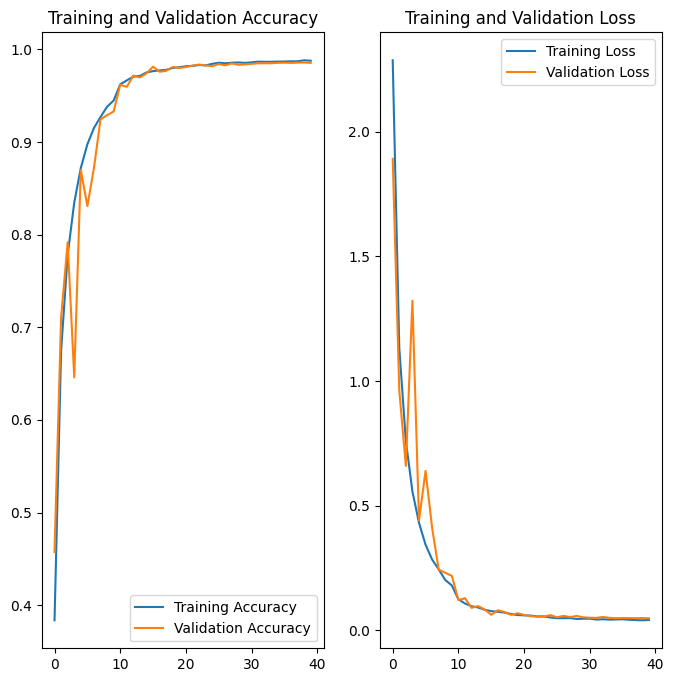

In [ ]:
# Extract training accuracy and validation accuracy values from the training history
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Extract training loss and validation loss values from the training history
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Define the range of epochs (x-axis values for the plots)
epochs_range = range(epochs)

# Create a figure with two subplots (1 row, 2 columns) for accuracy and loss visualization
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)  # Subplot for accuracy

# Plot training accuracy and validation accuracy over the epochs
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Add a legend to the plot, specifying the location
plt.legend(loc='lower right')

# Set the title for the subplot
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)  # Subplot for loss

# Plot training loss and validation loss over the epochs
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Add a legend to the plot, specifying the location
plt.legend(loc='upper right')

# Set the title for the subplot
plt.title('Training and Validation Loss')

# Display the plots
plt.show()

# **Displaying the Model's Predictions**

In [ ]:
true_labels = []
predicted_labels = []

# Get prediction labels vs true labels on the testing dataset
for images, labels in test_set:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_class_indices = np.argmax(predictions, axis=1)
    predicted_labels.extend(predicted_class_indices)

4/4 [==============================] - 0s 14ms/step


**Results**

Overall, the model seems to perform decently well with high precision, recall, and f1-scores throughout most of the 38 classes. The 98% accuracy demonstrates that the model is pretty accurate at identifying the plant diseases throughout the testing dataset as well.

In [ ]:
# Display precision, recall, f1-score, and number of images per class
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        38
           3       0.98      1.00      0.99        46
           4       0.96      1.00      0.98        53
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        37
           7       0.94      0.92      0.93        36
           8       1.00      1.00      1.00        44
           9       0.94      0.98      0.96        49
          10       1.00      1.00      1.00        38
          11       0.98      0.96      0.97        57
          12       0.96      0.98      0.97        46
          13       1.00      1.00      1.00        41
          14       1.00      1.00      1.00        33
          15       1.00      1.00      1.00        56
          16       0.98      0.98      0.98        48
          17       0.98    

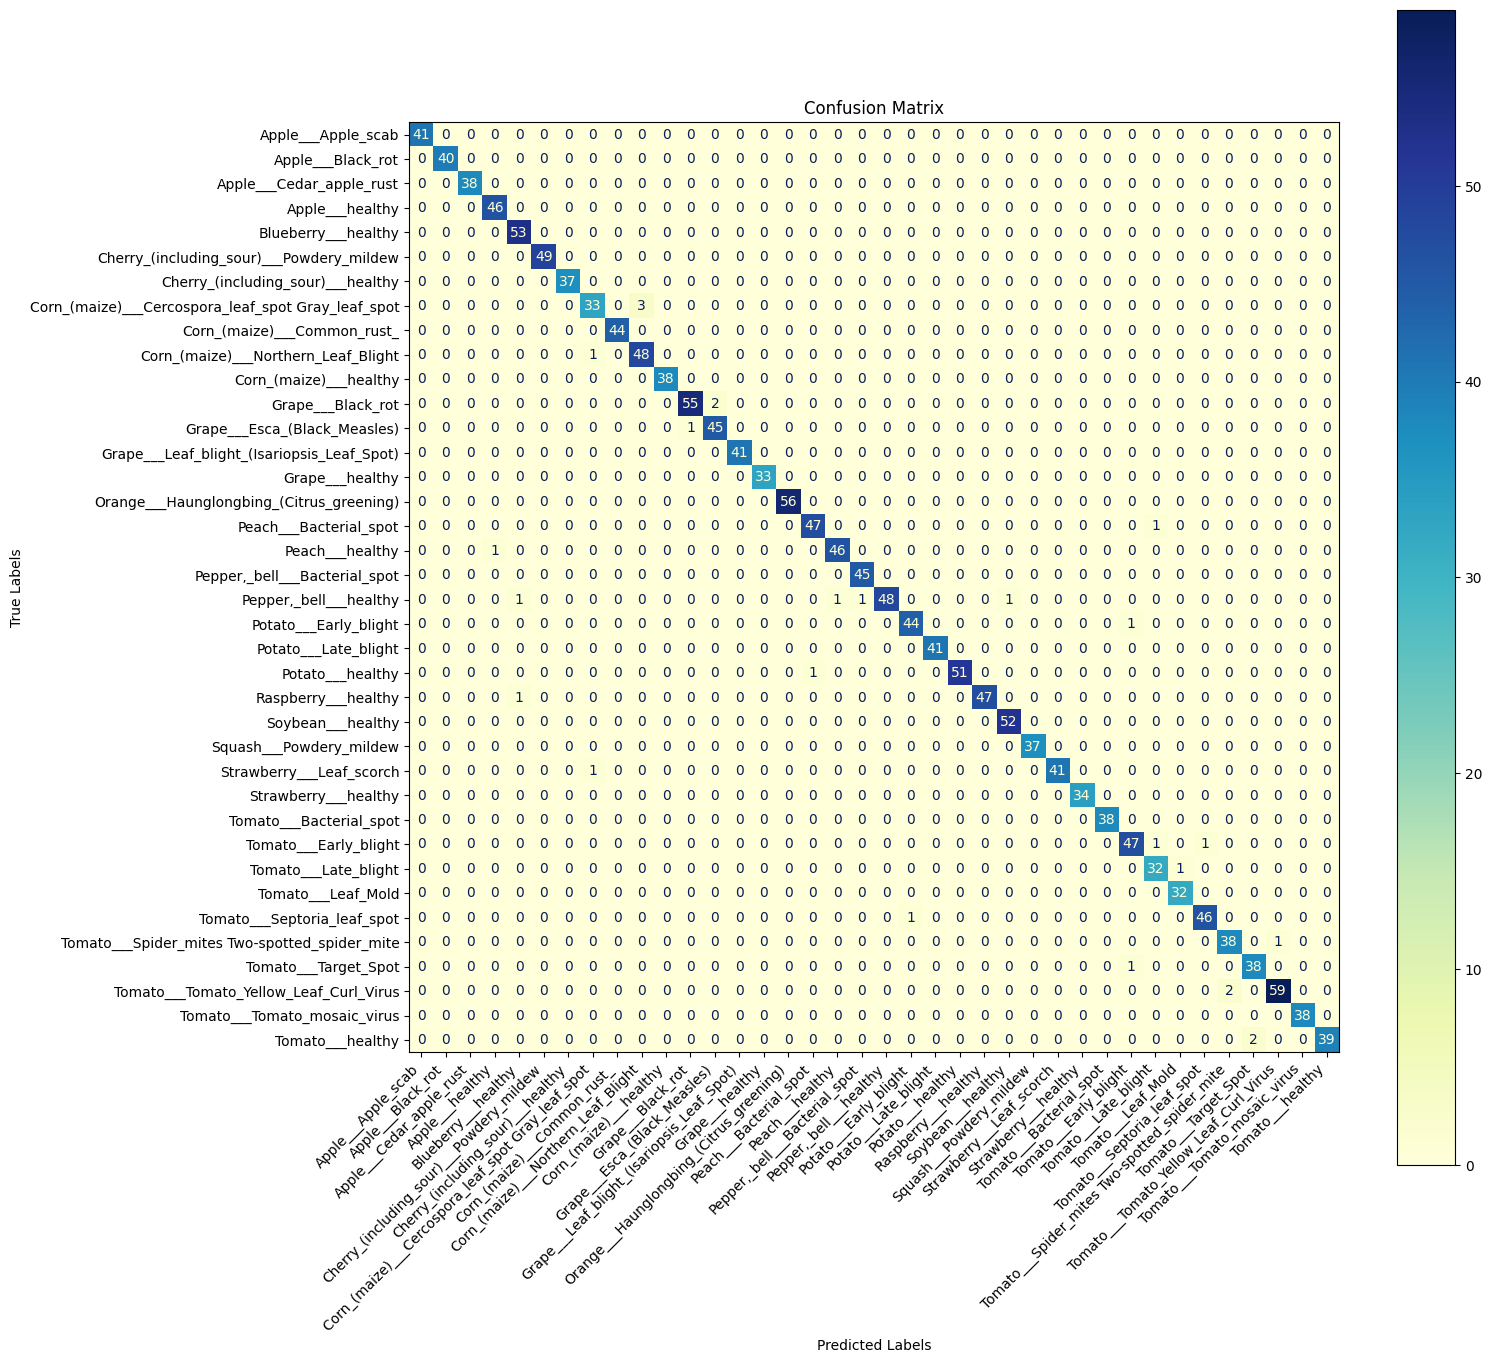

In [ ]:
# Confusion matrix calculation
cm = confusion_matrix(true_labels, predicted_labels)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1, 39)))

# Plot the confusion matrix in yellow green blue with a colorbar
im = disp.plot(ax=ax, colorbar=True, cmap='YlGnBu', values_format='d')

# Set the labels for class names on both axes
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)

# Set titles and labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()